# Предобработка данных поездок и погодных условий

В этой тетрадке выполняется полный процесс подготовки данных о поездках и погоде перед дальнейшим анализом и построением моделей. Основная цель — получить **чистый, непротиворечивый и готовый к анализу набор данных**, учитывающий как характеристики поездок, так и погодные условия.

Обрабатываемые данные включают:
- Информацию о поездках: маршруты, время, стоимость, длительность и т.п.
- Погодные показатели: температура, осадки, ветер, облачность, солнечная инсоляция.

Процесс подготовки данных включает следующие ключевые этапы:

1. **Импорт библиотек и загрузка данных**
   Загрузка исходных CSV-файлов, проверка структуры данных и базовые операции по чтению.

2. **Переименование колонок**
   Приведение названий столбцов к единому формату `snake_case` для удобства дальнейшей обработки.

3. **Очистка данных о поездках**
   - Удаление дубликатов
   - Нормализация адресов и районов
   - Обработка пропусков (восстановление значений медианой по маршрутам)
   - Удаление экстремальных значений методом IQR
   - Создание новых признаков (длительность, стоимость, скорость, день недели)
   - Преобразование типов и категоризация признаков

4. **Очистка данных о погоде**
   - Удаление лишних столбцов и служебных строк
   - Преобразование типов данных
   - Создание признаков месяца и часа
   - Заполнение пропусков с учётом цикличности (месяц/час) и интерполяции

5. **Сохранение итоговых файлов**
   Формирование полностью очищенных датасетов, готовых к дальнейшему анализу и моделированию.

## 1. Импорт библиотек

In [ ]:
import os

import pandas as pd

from utils.cleaning import (
    normalize_street, normalize_district, normalize_day_of_week,
    drop_outlers, fill_na_median_by_group, interpolate_time
)
from utils.features import get_total_price
from utils.vizualization import plot_hist_boxplot

## 2. Чтение и подготовка данных

Задаём пути к файлам, параметры чтения CSV и загружаем данные с проверкой ошибок.

In [33]:
HOME = os.getcwd().removesuffix("/notebooks")

In [34]:
# Настраиваем словари с параметрами чтения CSV: путь, кодировка, дата-колонки
rides_options = {
    "filepath_or_buffer": f"{HOME}/data/rides.csv",
    "encoding": "utf-8",
    "parse_dates": ["Start Date", "End Date"],
}

weather_options = {
    "filepath_or_buffer": f"{HOME}/data/weather.csv",
    "encoding": "utf-8",
    "parse_dates": ["Datetime"]
}

try:
    rides_data = pd.read_csv(**rides_options)
    weather_data = pd.read_csv(**weather_options)
except pd.errors.ParserError as e:
    print(f"Error: {e}")
    rides_data = pd.read_csv(**rides_options, sep=";")
    weather_data = pd.read_csv(**weather_options, sep=";")

## 3. Переименование колонок

Приводим названия колонок к snake_case для удобства работы.

In [35]:
rides_data.rename(lambda col: col.strip().lower().replace(" ", "_"), axis="columns", inplace=True)

weather_data.rename(lambda col: col.strip().lower().replace(" ", "_"), axis="columns", inplace=True)

## 4. Очистка данных о поездках

### 4.1. Удаление дубликатов

In [36]:
rides_data = rides_data.drop_duplicates()

rides_data.duplicated().sum()

np.int64(0)

Удаляем неявные дубликаты, повторяющиеся по id и времени старта.

### 4.2. Нормализация адресов и районов

Применяем функции из модуля `cleaning` для стандартизации названий улиц и районов.

In [37]:
rides_data["start_location"] = rides_data["start_location"].apply(normalize_street)
rides_data["end_location"] = rides_data["end_location"].apply(normalize_street)

In [38]:
rides_data["start_district"] = rides_data["start_district"].apply(normalize_district)
rides_data["end_district"] = rides_data["end_district"].apply(normalize_district)

### 4.3. Удаление пропусков
На этапе первичного анализа было выявлено, что пропусков в данных крайне мало (менее 1%). Для пропусков в колонке distance сначала применяется заполнение медианным значением для соответствующего маршрута (start_location → end_location). Это позволяет восстановить расстояние поездки на основе аналогичных маршрутов.

После заполнения оставшиеся пропуски (например, в других колонках) можно безопасно удалить, так как их доля крайне мала и это не повлияет на общую структуру данных.


In [39]:
# Заполняем пропуски в distance медианой по маршруту
rides_data = fill_na_median_by_group(rides_data, ["distance"], ["start_location", "end_location"])

# Удаляем оставшиеся строки с пропусками
rides_data.dropna(inplace=True)

# Проверка, что пропусков больше нет
rides_data.isnull().sum()

id                0
start_date        0
end_date          0
start_location    0
start_district    0
end_location      0
end_district      0
distance          0
promo             0
dtype: int64

### 4.4. Удаление экстремальных значением

Применяем метод межквартильного размаха (IQR) для очистки датасета от экстремальных значений в колонке `distance`.

In [40]:
rides_data = drop_outlers(rides_data, "distance", k=3)
rides_data = rides_data[rides_data["distance"] >= 200]

### 4.5. Создание новых признаков

Добавляем день недели и перемещаем колонку на удобную позицию.

In [41]:
rides_data["day_of_week"] = rides_data["start_date"].dt.dayofweek

col = rides_data.pop('day_of_week')
rides_data.insert(3, 'day_of_week', col)

Добавляем итоговое время поездки.

In [42]:
td = rides_data["end_date"] - rides_data["start_date"]

rides_data["duration_minutes"] = (td.dt.total_seconds() / 60).round()

Добавляем итоговую стоимость поездки.

In [43]:
rides_data["total_price"] = rides_data.apply(get_total_price, axis=1)

Добавляем признак скорости поездки (`km/ч`):

In [44]:
rides_data["speed_km_per_h"] = (rides_data["distance"] / 1000) / (rides_data["duration_minutes"] / 60)

Создаем временной признак: начало поездки, округлённое до часа (для последующего объединения с погодой)

In [45]:
rides_data['start_hour'] = rides_data['start_date'].dt.floor('h')

### 4.6 Оценка адекватность новых факторов

Рассмотрим распределения созданных признаков:

In [46]:
new_factors = ["duration_minutes", "total_price", "speed_km_per_h"]

In [47]:
rides_data[new_factors].describe().T

,count,mean,std,min,25%,50%,75%,max
duration_minutes,93286.0,26.371031,9.954598,3.00000,19.000000,25.0000,31.000000,85.000000
total_price,93286.0,178.542407,65.778950,20.00000,132.000000,168.0000,210.000000,625.000000
speed_km_per_h,93286.0,9.198018,2.069503,2.28973,7.797418,9.1824,10.566289,29.322857


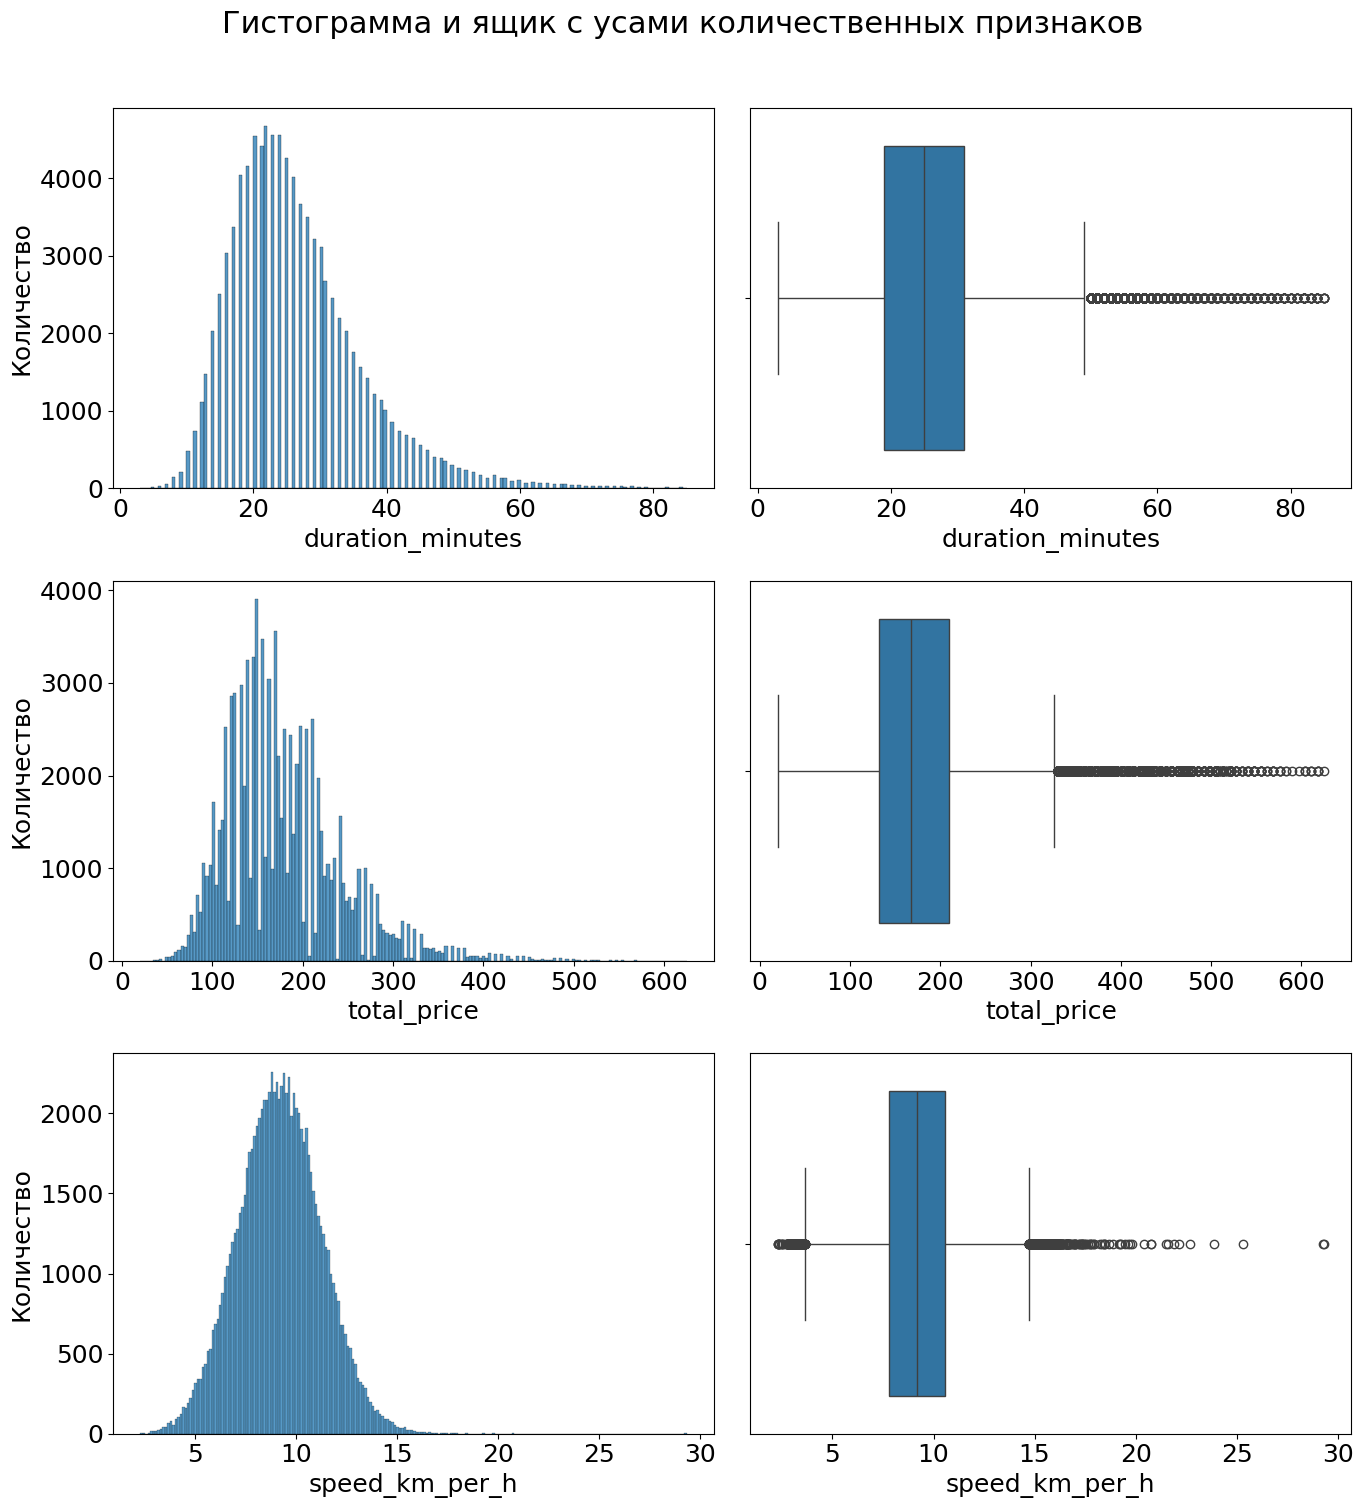

In [48]:
plot_hist_boxplot(rides_data, ["duration_minutes", "total_price", "speed_km_per_h"])

**Вывод:**

Все три признака имеют корректные диапазоны значений и реалистичные распределения. Аномалий, технических выбросов или ошибочных записей не выявлено — дополнительная очистка для данного блока не требуется.

### 4.7. Преобразование типов

Колонка `promo` содержит бинарные значения (1 — акция использована, 0 — нет).
Преобразуем её в категориальный признак и заменяем значения на "Да" / "Нет" для удобства анализа и визуализации.

In [49]:
rides_data["promo"] = rides_data["promo"].apply(lambda val: "Да" if val == 1 else "Нет")

Преобразуем числовые значения дня недели (0–6) в читаемые названия на русском языке с помощью функции normalize_day_of_week.
Колонка становится категориальной для удобства анализа и визуализации.

In [50]:
rides_data["day_of_week"] = rides_data["day_of_week"].apply(normalize_day_of_week)

## 5. Очистка данных о погоде

### 5.1. Удаление ненужных столбцов

Удаляется колонка wind_gust, поскольку она дублирует информацию о порывах ветра.

In [51]:
weather_data = weather_data.drop("wind_gust", axis=1)

### 5.2. Удаление дубликатов

In [52]:
weather_data = weather_data.drop_duplicates()

weather_data.duplicated().sum()

np.int64(0)

### 5.3. Удаление первой служебной строки

Первая строка содержит единицы измерения (°C, km/h, mm и т.п.), которые не нужны для анализа, поэтому её удаляем.

In [53]:
weather_data = weather_data.iloc[1:].reset_index(drop=True)

### 5.4. Преобразование текстовых колонок в числовые

* Столбцы с типом object могут содержать текстовые значения.
* Используем pd.to_numeric(errors="coerce"), чтобы некорректные значения превратить в NaN.
* Это важно для дальнейшей интерполяции и работы с временным рядом.

In [54]:
cat_cols = weather_data.select_dtypes(include=[object]).columns
for cat in cat_cols:
    weather_data[cat] = pd.to_numeric(weather_data[cat], errors="coerce")

### 5.5. Создание новых признаков

Добавляем признак `month`.

In [55]:
weather_data["month"] = weather_data["datetime"].dt.month

col = weather_data.pop('month')
weather_data.insert(1, 'month', col)

Добавляем признак `hour`.

In [56]:
weather_data['hour'] = weather_data['datetime'].dt.hour

col = weather_data.pop('hour')
weather_data.insert(2, 'hour', col)

### 5.6. Заполнение пропусков в погодных признаках

In [57]:
# Заполняем медианой
weather_data = fill_na_median_by_group(
    weather_data, ['precipitation_total', 'temperature', 'sunshine_duration'], ['month', 'hour']
)

# Интерполируем оставшиеся признаки
weather_data = interpolate_time(
    weather_data, ['wind_speed', 'cloud_cover_total']
)

## 6. Объединяем данные о поездках с погодой по часу начала поездки

In [58]:
rides_weather_data = rides_data.merge(
    weather_data,
    left_on='start_hour',
    right_on='datetime',
    how='left'
)

Проверяем, что объединение датасетов прошло корректно

In [59]:
rides_weather_data.sample(5)

,id,start_date,end_date,day_of_week,start_location,start_district,end_location,end_district,distance,promo,...,speed_km_per_h,start_hour,datetime,month,hour,temperature,precipitation_total,wind_speed,cloud_cover_total,sunshine_duration
47622,150039,2023-06-15 17:37:37,2023-06-15 18:09:10,четверг,дзержинского,центральный,победы,юго-восточный,3330.0,Нет,...,6.243750,2023-06-15 17:00:00,2023-06-15 17:00:00,6,17,26.430244,0.0,8.669949,24.0,45.454544
26671,128169,2023-05-24 18:35:55,2023-05-24 19:05:06,среда,западная,ленинский,нагорная,центральный,4858.0,Нет,...,10.051034,2023-05-24 18:00:00,2023-05-24 18:00:00,5,18,15.080245,0.0,14.113653,70.0,17.575756
67505,170773,2023-07-06 17:20:45,2023-07-06 17:43:03,четверг,лермонтова,ленинский,чкалова,юго-восточный,3294.0,Нет,...,8.983636,2023-07-06 17:00:00,2023-07-06 17:00:00,7,17,27.540245,0.0,4.510787,13.0,52.121212
72174,175653,2023-07-10 18:19:36,2023-07-10 18:48:59,понедельник,партизанская,ленинский,юбилейная,юго-восточный,3763.0,Нет,...,7.785517,2023-07-10 18:00:00,2023-07-10 18:00:00,7,18,30.370245,0.0,0.509117,17.0,49.696968
57817,160692,2023-06-25 22:08:24,2023-06-25 22:26:42,воскресенье,ломоносова,октябрьский,маяковского,центральный,4067.0,Нет,...,13.556667,2023-06-25 22:00:00,2023-06-25 22:00:00,6,22,21.040245,0.0,2.902413,0.0,0.000000


## 7. Сохраняем очищенные файлы

In [ ]:
rides_data.to_csv(f"{HOME}/data/cleaned_rides.csv", index=False)
weather_data.to_csv(f"{HOME}/data/cleaned_weather.csv", index=False)
rides_weather_data.to_csv(f"{HOME}/data/rides_weather_data.csv", index=False)